In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

___
## Read in Cleaned Post CSV

In [3]:
df_posts = pd.read_csv('../data/cleaned_NVIDIA_AMD.csv', low_memory=False, index_col=0)

In [4]:
df_posts.head()

,subreddit,selftext,title,author,num_comments
1,nvidia,Which should I use and are they both safe? [Pr...,NvidiaProfileInspector or NvidiaInspector?,DeepSpaceHorizon,0.0
2,nvidia,before march fifth my vids looked like this \n...,shadowplay is wierdpease help me,bob6572,0.0
4,nvidia,CPU: Intel Core i7-8700 3.20GHz\nRAM: 16GB\nGP...,Nvidia Gefore GTX 1060 6gb replacement options?,shukii89,0.0
5,nvidia,I have an MSI Venus 2X RTX 3060 Card and I've ...,Did latest driver update break features like R...,cr6sxwastaken,0.0
6,nvidia,Hi \n\nI built my PC last May and no problem s...,Msi Suprim 3080 ti downclock itself by 250mhz ...,Kooky-Introduction70,0.0


In [5]:
df_posts.isnull().sum()

subreddit       0
selftext        0
title           0
author          0
num_comments    0
dtype: int64

---

### Initial EDA and Visualization
- Before we dive into the selftext and title, I want to use the columns we have at the moment to get a high level snap shot of the two different subreddits
- Looking to plot:
    - Average number of comments per subreddit
    - Title and Selftext length per subreddit
    - Word Count for Title and Selftext per subreddit
- Before plotting, let's add 4 columns to the dataframe:
    - selftext_word_count
    - selftext_length
    - title_word_count
    - title_length

In [6]:
df_posts['selftext_word_count'] = [len(selftext.split()) for selftext in df_posts['selftext']]
df_posts['selftext_length'] = [len(selftext) for selftext in df_posts['selftext']]
df_posts['title_word_count'] = [len(title.split()) for title in df_posts['title']]
df_posts['title_length'] = [len(title) for title in df_posts['title']]

In [7]:
df_posts.head(1)

,subreddit,selftext,title,author,num_comments,selftext_word_count,selftext_length,title_word_count,title_length
1,nvidia,Which should I use and are they both safe? [Pr...,NvidiaProfileInspector or NvidiaInspector?,DeepSpaceHorizon,0.0,14,179,3,42


''

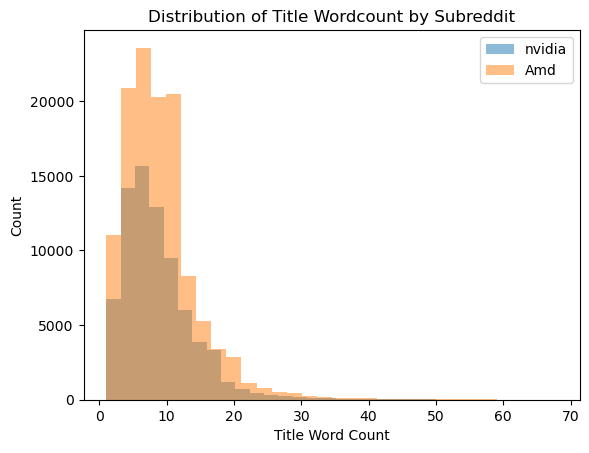

In [59]:
fig = plt.figure()

for subreddit in df_posts.subreddit.unique():
    plt.hist(
        df_posts[df_posts['subreddit'] == subreddit].title_word_count,
        alpha = .5, #handle overlap with opactity
        label = subreddit,
        bins = 30,
    )
    
plt.legend()
plt.title('Distribution of Title Wordcount by Subreddit')
plt.xlabel('Title Word Count')
plt.ylabel('Count');
;

- The distributions of Title word count are strikingly similar between the two subreddits
- The only reason AMD is currently overshadowing NVIDIA is because of the difference in post population after cleaning
- As to how this affects the model, down the line after a couple of iterations I was contemplating using additional features such as Title Wordcount, etc. as potential differentiators, but given the relatable distributions, that probably wouldn't help with the noise

''

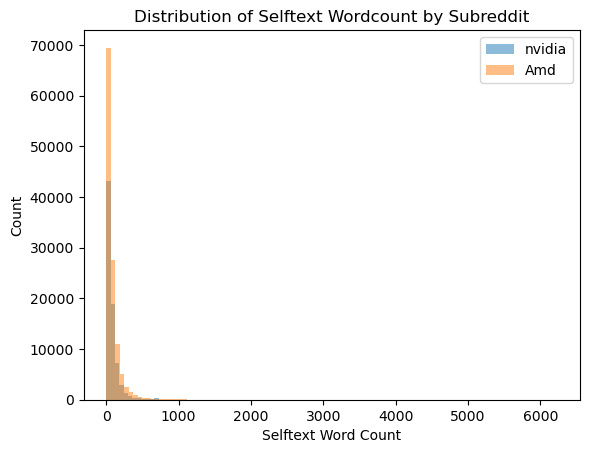

In [60]:
fig = plt.figure()

for subreddit in df_posts.subreddit.unique():
    plt.hist(
        df_posts[df_posts['subreddit'] == subreddit].selftext_word_count,
        alpha = .5, #handle overlap with opactity
        label = subreddit,
        bins = 100,
    )
    
plt.legend()
plt.title('Distribution of Selftext Wordcount by Subreddit')
plt.xlabel('Selftext Word Count')
plt.ylabel('Count');
;

- Similar to Title word count, distributions are mirrors of each other
- Not the most readable, would not include this in a presentation

''

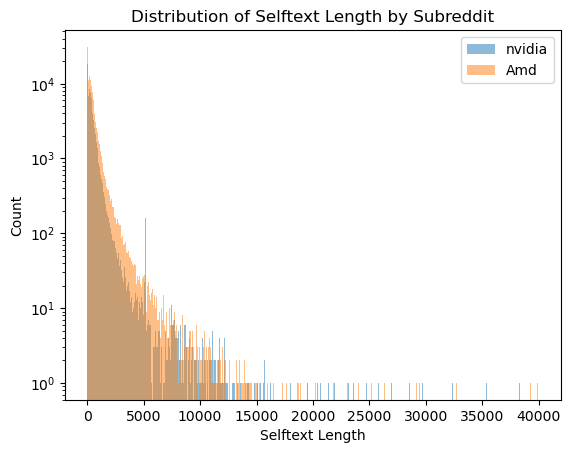

In [52]:
fig = plt.figure()

for subreddit in df_posts.subreddit.unique():
    plt.hist(
        df_posts[df_posts['subreddit'] == subreddit].selftext_length,
        alpha = .5, #handle overlap with opactity
        label = subreddit,
        bins = 500,
        log=True
    )
    
plt.legend()
plt.title('Distribution of Selftext Length by Subreddit')
plt.xlabel('Selftext Length')
plt.ylabel('Count');
;

- I was curious if selftext length also followed the same pattern, but also wanted to experiment with visualizing extreme values hence the log parameter.

In [71]:
df_posts['subreddit'].value_counts()

Amd       120094
nvidia     75875
Name: subreddit, dtype: int64

In [70]:
df_posts.groupby('subreddit')['author'].nunique().sort_values(ascending=False)

subreddit
Amd       47167
nvidia    41560
Name: author, dtype: int64

- Despite having a ~45k difference in available posts/observations, the number of unique authors within each subreddit is surprisingly closer than expected.
- Pure speculation but this could signify that there are more duplicate authors within AMD than there are in NVIDIA, which could be explained by NVIDIA's market share.

---

- Separately, curious to see if the length of a post has any relation to the number of comments, afterwards will move on to breaking down the selftext and title features to jumpstart to the modeling process.

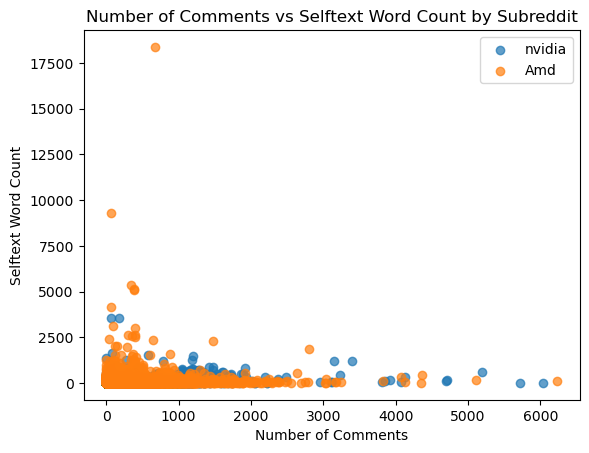

In [81]:
for s in df_posts.subreddit.unique():
    plt.scatter(data = df_posts[df_posts.subreddit == s],
                x = 'selftext_word_count',
                y = 'num_comments',
               label = s,
               alpha = 0.7)

plt.title('Number of Comments vs Selftext Word Count by Subreddit')
plt.xlabel('Number of Comments')
plt.ylabel('Selftext Word Count')

plt.legend();

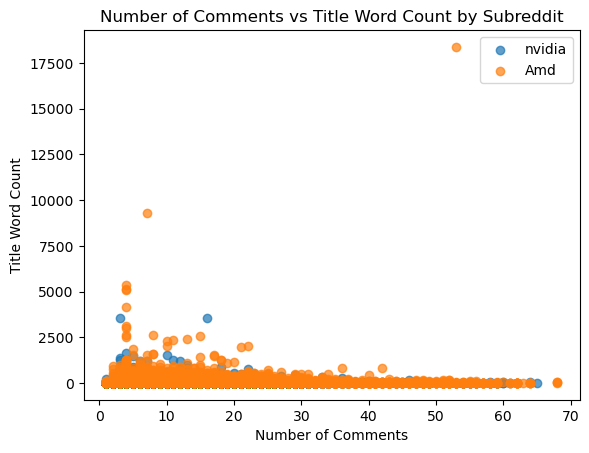

In [88]:
for s in df_posts.subreddit.unique():
    plt.scatter(data = df_posts[df_posts.subreddit == s],
                x = 'title_word_count',
                y = 'num_comments',
               label = s,
               alpha = 0.7)

plt.title('Number of Comments vs Title Word Count by Subreddit')
plt.xlabel('Number of Comments')
plt.ylabel('Title Word Count')

plt.legend();

- The subreddits continue to behave similarly
- Only callable difference is with the help of outliers wherein there are limited, specific instances where Title/Selftext length is exponentially larger than the base set, with a high amount of comments.

___

### Additional Descriptive Statistics

In [74]:
df_posts.describe()

,num_comments,selftext_word_count,selftext_length,title_word_count,title_length
count,195969.000000,195969.000000,195969.000000,195969.000000,195969.000000
mean,16.334364,80.652996,470.205507,9.005868,49.207033
std,68.494011,130.748887,835.166598,5.567995,29.655443
min,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2.000000,13.000000,78.000000,5.000000,30.000000
50%,8.000000,50.000000,277.000000,8.000000,43.000000
75%,17.000000,100.000000,560.000000,11.000000,61.000000
max,18378.000000,6230.000000,39948.000000,68.000000,301.000000


- After visualizing a couple of different histograms, scatter plots, etc. I wanted to double check the describe table for discrepancies/outliers.
- This is something I should have paid attention to during the clean process because from the describe table there are pretty clear outliers in each numerical category.
- Ultimately the first dozen iterations of the models will only be on title text and self text without any other kinds of input, but I am curious if the additional words within the selftext and title outliers will create additional noise or a potential signal for the classification of subreddits?

In [93]:
df_posts.groupby('subreddit')[['title_length', 'title_word_count']].mean()

,title_length,title_word_count
subreddit,,
Amd,49.780655,9.116317
nvidia,48.299110,8.831051


In [92]:
df_posts.groupby('subreddit')[['selftext_length', 'selftext_word_count']].mean()

,selftext_length,selftext_word_count
subreddit,,
Amd,481.189502,82.247223
nvidia,452.820178,78.129674


___
## Model Version 2 EDA and Clean
- For Version 2 we are going to examine outliers in posts as well as clean out:
    - Punctuation
    - Any posts with selftext_word_count length less than 10
    - Any posts with selftext wordcount above 2500 as seen in the visualizations above
- Additionally we are going to see if we can identify when posts contain references too:
    - Intel GPU Models
    - NVIDIA GPU Models
    - AMD GPU Models
    - Plot the results

In [8]:
df_posts.describe()

,num_comments,selftext_word_count,selftext_length,title_word_count,title_length
count,195969.000000,195969.000000,195969.000000,195969.000000,195969.000000
mean,16.334364,80.652996,470.205507,9.005868,49.207033
std,68.494011,130.748887,835.166598,5.567995,29.655443
min,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2.000000,13.000000,78.000000,5.000000,30.000000
50%,8.000000,50.000000,277.000000,8.000000,43.000000
75%,17.000000,100.000000,560.000000,11.000000,61.000000
max,18378.000000,6230.000000,39948.000000,68.000000,301.000000


In [9]:
df_posts.shape

(195969, 9)

---
### Removing Selftext min and max outliers

In [12]:
# Remove all submissions that have a selftext word count greater than or equal to 2500
df_posts = df_posts[df_posts['selftext_word_count'] < 2500]

In [13]:
df_posts.shape

(195933, 9)

In [22]:
df_posts.loc[:,['selftext_word_count','title_word_count','selftext_length']].describe()

,selftext_word_count,title_word_count,selftext_length
count,195933.000000,195933.000000,195933.000000
mean,79.981167,9.006012,465.799819
std,120.260487,5.568254,763.898732
min,0.000000,1.000000,1.000000
25%,13.000000,5.000000,78.000000
50%,50.000000,8.000000,277.000000
75%,100.000000,11.000000,560.000000
max,2485.000000,68.000000,21373.000000


There are still reddit posts with an extreme amount of words/length, let's look to remove posts that are above the 95% mark

In [24]:
q95 = df_posts['selftext_length'].quantile(0.95)

In [25]:
df_test = df_posts[df_posts['selftext_length'] <= q95]

In [27]:
df_test.loc[:,['selftext_word_count','title_word_count','selftext_length']].describe()

,selftext_word_count,title_word_count,selftext_length
count,186145.000000,186145.000000,186145.000000
mean,60.429117,8.940955,339.513729
std,59.002369,5.557039,330.227529
min,0.000000,1.000000,1.000000
25%,10.000000,5.000000,63.000000
50%,46.000000,8.000000,256.000000
75%,90.000000,11.000000,501.000000
max,314.000000,68.000000,1506.000000


In [28]:
df_posts.shape[0]-df_test.shape[0]

9788

In [29]:
((df_posts.shape[0]-df_test.shape[0])/df_posts.shape[0])*100

4.9955852255618

- Removing observations above the 95th for selftext_length results in a loss of 9788 observations
- That's only a 5 percent loss of observations, let's finalize that for version 2

In [30]:
df_posts = df_posts[df_posts['selftext_length'] <= q95]

In [36]:
df_posts.shape

(186145, 9)

In [31]:
df_test.loc[:,['selftext_word_count','title_word_count','selftext_length']].describe()

,selftext_word_count,title_word_count,selftext_length
count,186145.000000,186145.000000,186145.000000
mean,60.429117,8.940955,339.513729
std,59.002369,5.557039,330.227529
min,0.000000,1.000000,1.000000
25%,10.000000,5.000000,63.000000
50%,46.000000,8.000000,256.000000
75%,90.000000,11.000000,501.000000
max,314.000000,68.000000,1506.000000


In [32]:
195969 - df_posts.shape[0]

9824

### Removing Min Outliers of Selftext word count and length
- Let's work on reducing outliers on the min side and then we can start cleaning punctuation from the data.
- We'll need to keep track of the total observation difference between V1 and V2 when comparing model performance
    - So far the total difference is 9824
- In a similar fashion let's see the difference when we remove posts under the 5th percent for selftext_word_count to capture any potential posts with less than ~10 words
    - 5%,10%, & 15% wasn't enough to remove posts with only 1 word, but it did remove posts with 0. Let's try to just remove posts with selftext_word_counts less than 10.
    - Tried to remove selftext_word_count that were less than ten and it resulted in a reduction of ~47k observations which would make the two versions incomparable.
- Let's try removing word counts = to 1 and see if that is more manageable
    - There are 41k posts with 1 word in the selftext. Before removing let's check to see their contents and make the decision based on that.

In [67]:
df_posts.shape[0]-df_test.shape[0]

41904

In [65]:
df_test = df_posts[df_posts['selftext_word_count'] > 1]

In [66]:
df_test.shape

(144241, 9)

In [59]:
df_test.loc[:,['selftext_word_count','title_word_count','selftext_length']].describe()

,selftext_word_count,title_word_count,selftext_length
count,139107.000000,139107.000000,139107.000000
mean,80.326396,8.490694,448.551525
std,55.592542,4.905882,313.680817
min,11.000000,1.000000,38.000000
25%,38.000000,5.000000,211.000000
50%,65.000000,7.000000,361.000000
75%,108.000000,11.000000,603.000000
max,314.000000,68.000000,1506.000000


In [68]:
one_word_posts = df_posts[df_posts['selftext_word_count'] == 1]

In [69]:
one_word_posts.head()

,subreddit,selftext,title,author,num_comments,selftext_word_count,selftext_length,title_word_count,title_length
257,nvidia,SHALOM,mods suck,BabyAstronaut4,0.0,1,6,2,9
303,nvidia,[https://www.prnewswire.com/news-releases/bria...,"BRIA to Offer Its Comprehensive, Responsibly S...",theaiguru,0.0,1,376,18,132
394,nvidia,Halp!,Will my 4090 fit in a Corsair 4000d case? Will...,Hillbillyheist,0.0,1,5,14,65
677,nvidia,Title,Is evga the only graphics card company that ha...,zohaib1212121,0.0,1,5,15,92
833,nvidia,Problem,"Hello everyone, I have a pany 3080 graphics ca...",Conscious_Monk_1925,0.0,1,7,51,271


- There seems to be an interesting mix of one word selftexts posts just from the above 5 rows
- Outside of the first row, the community of NVIDIA seems to get more value out of the title field than the self text field, primarily introducing the post or asking questions in the title.
- Let me check the average title length for both communities before making my decision.

In [77]:
df_posts[(df_posts['selftext_word_count'] == 1) & (df_posts['subreddit'] == 'Amd')].describe()



,num_comments,selftext_word_count,selftext_length,title_word_count,title_length
count,26240.000000,26240.0,26240.000000,26240.000000,26240.000000
mean,7.130602,1.0,11.046341,10.459337,57.114596
std,23.073200,0.0,20.391953,7.130538,38.083990
min,0.000000,1.0,1.000000,1.000000,1.000000
25%,0.000000,1.0,9.000000,6.000000,32.000000
50%,2.000000,1.0,9.000000,9.000000,49.000000
75%,7.000000,1.0,9.000000,13.000000,71.000000
max,1270.000000,1.0,903.000000,68.000000,300.000000


In [79]:
df_posts[(df_posts['selftext_word_count'] == 1) & (df_posts['subreddit'] == 'nvidia')].describe()


,num_comments,selftext_word_count,selftext_length,title_word_count,title_length
count,15659.000000,15659.0,15659.000000,15659.000000,15659.000000
mean,5.013155,1.0,9.947762,9.982310,54.628073
std,16.590685,0.0,14.636663,6.812434,36.195542
min,0.000000,1.0,1.000000,1.000000,1.000000
25%,0.000000,1.0,9.000000,6.000000,31.000000
50%,1.000000,1.0,9.000000,8.000000,47.000000
75%,5.000000,1.0,9.000000,12.000000,68.000000
max,560.000000,1.0,811.000000,64.000000,300.000000


- Both communities follow a similar pattern in which 1 word selftext generally indicates a mean title word count of ~10
- I am going to make the decision to keep 1 word selftext posts

In [80]:
df_posts.shape

(186145, 9)

---
### Removing Punctuation and Links

Removing URLS with Regex
- The url_pattern regular expression matches URLs that start with 'http' or 'www', and includes any non-whitespace characters after that until the next whitespace character or the end of the string.
- This isn't a catch all expression but should capture most URLS

In [82]:
url_pattern = re.compile(r'http\S+|www\S+')
df_posts['selftext'] = df_posts['selftext'].apply(lambda x: url_pattern.sub('', x))

Removing Punctuation with Regex
-  The lambda function takes a string of text and replaces any punctuation character that matches the punctuation_pattern regular expression with an empty string resulting in spaces instead of punctuation

In [83]:
punctuation_pattern = re.compile(r'[^\w\s]+')
df_posts['selftext'] = df_posts['selftext'].apply(lambda x: punctuation_pattern.sub('', x))
df_posts['title'] = df_posts['title'].apply(lambda x: punctuation_pattern.sub('', x))

The next is a bit of an edge case potentially, but when modeling and looking over tokenized data, saw some references to phrases like "[deleted]", let's look to use regex to remove those as well

In [86]:
deleted_pattern = re.compile(r'\[deleted\]')
df_posts['selftext'] = df_posts['selftext'].apply(lambda x: deleted_pattern.sub('', x))
df_posts['title'] = df_posts['title'].apply(lambda x: deleted_pattern.sub('', x))

---
### Finding GPU Model Identifiers in Reddit submissions using regex

- Intel's GPU pattern is longer because it is much more specific to the individual models of the A750, A770 8GB, and A770 16 GB
- Luckily NVIDIA and AMD follow similar patters of:
    - NVIDIA or AMD
    - a whitespace
    - 1 or more word characters like GTX, GeForce, Radeon, RX etc.
    - a whitespace
    - Finishing with 1 or more non whitespace characters which will be either model numbers or further text
- I don't believe, like the url patter, that these are catch-alls, but it should give us a good indicator of rows that include one, or more models numbers
    - Because they arent catch-alls, instead of counting their appearance, let's create a new column for each GPU manufacturer and set a boolean value if they are present or not
    - before creating, let's create a column that is the combination of both the title and selftext columns for ease of search

In [90]:
intel_gpu_pattern = re.compile(r'\bIntel\s+A(?:750|770\s+8GB|770\s+16GB)\b')

In [91]:
nvidia_gpu_pattern = re.compile(r'NVIDIA\s\w+\s\S+')

In [92]:
amd_gpu_pattern = re.compile(r'AMD\s\w+\s\S+')

In [93]:
df_posts['text'] = df_posts['title'] + " " + df_posts['selftext']

In [94]:
df_posts['intel_gpu'] = df_posts['text'].str.contains(intel_gpu_pattern)
df_posts['nvidia_gpu'] = df_posts['text'].str.contains(nvidia_gpu_pattern)
df_posts['amd_gpu'] = df_posts['text'].str.contains(amd_gpu_pattern)

In [95]:
df_posts.head()

,subreddit,selftext,title,author,num_comments,selftext_word_count,selftext_length,title_word_count,title_length,text,intel_gpu,nvidia_gpu,amd_gpu
1,nvidia,Which should I use and are they both safe Prof...,NvidiaProfileInspector or NvidiaInspector,DeepSpaceHorizon,0.0,14,179,3,42,NvidiaProfileInspector or NvidiaInspector Whic...,False,False,False
2,nvidia,before march fifth my vids looked like this \n...,shadowplay is wierdpease help me,bob6572,0.0,102,677,5,32,shadowplay is wierdpease help me before march ...,False,False,False
4,nvidia,CPU Intel Core i78700 320GHz\nRAM 16GB\nGPU NV...,Nvidia Gefore GTX 1060 6gb replacement options,shukii89,0.0,155,775,7,47,Nvidia Gefore GTX 1060 6gb replacement options...,False,True,False
5,nvidia,I have an MSI Venus 2X RTX 3060 Card and Ive b...,Did latest driver update break features like R...,cr6sxwastaken,0.0,82,417,11,71,Did latest driver update break features like R...,False,False,False
6,nvidia,Hi \n\nI built my PC last May and no problem s...,Msi Suprim 3080 ti downclock itself by 250mhz ...,Kooky-Introduction70,0.0,178,980,9,54,Msi Suprim 3080 ti downclock itself by 250mhz ...,False,False,False


### Let's Visualize!

In [98]:
gpu_count = df_posts.groupby('subreddit')[['intel_gpu','nvidia_gpu','amd_gpu']].sum()

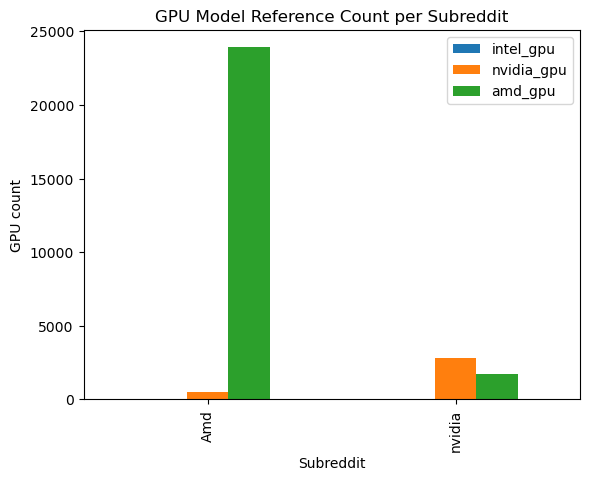

In [103]:
gpu_count.plot(kind='bar')
plt.xlabel('Subreddit')
plt.ylabel('GPU count')
plt.title('GPU Model Reference Count per Subreddit')
plt.show()

### Observations

- Our regex attempts at finding different gpu model references were successful, but unfortunately the results are now what we were hoping for.
- Both AMD and NVIDIA model numbers were picked up on, but there was either no reference to the newer Intel GPU Models, or our query was unsuccessful.
- After doing some research,if we had more time and resources we could potentially invest in a Named Entity Recognition Model.
    - https://towardsdatascience.com/named-entity-recognition-applications-and-use-cases-acdbf57d595e
    - We will recommend this approach as a more accurate/reliable way to be sure there is no reference of our latest models in these subreddits
    - Also, in future usecases we should expand our search to:
        - More Subreddits
        - Include comments as well
- That being said, let's save our newly cleaned dataframe, run our models, record our scores, and analyze if the additional steps helped or hurt our models


In [104]:
df_posts.columns

Index(['subreddit', 'selftext', 'title', 'author', 'num_comments',
       'selftext_word_count', 'selftext_length', 'title_word_count',
       'title_length', 'text', 'intel_gpu', 'nvidia_gpu', 'amd_gpu'],
      dtype='object')

In [107]:
df_posts.drop(columns=['author','num_comments','selftext',
                       'title','selftext_word_count','selftext_length',
                       'selftext_length','title_word_count','title_length',
                       'intel_gpu','nvidia_gpu','amd_gpu'], inplace=True)

In [108]:
df_posts.to_csv('../data/v2cleaned_NVIDIA_AMD.csv')